# TITLE 

## By Sarah Prusaitis, Rick Lataille, and Allison Ward

## Overview
overview/project intro here

## Business Problem
business problem paragraph here

## Data Limitations
data limitations info here

# EDA

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import time
from IPython.display import display, HTML

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer, word_tokenize, regexp_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
df1 = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'ISO-8859-1')

In [3]:
df2 = pd.read_csv('data/Apple_Product_Negative_ Tweets_Sheet1.csv', encoding = 'ISO-8859-1')

In [4]:
df1 = df1.rename(columns = {'tweet_text': 'tweet', 
                         'emotion_in_tweet_is_directed_at': 'product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

In [5]:
df = pd.concat([df1, df2], ignore_index = True)

In [6]:
df.shape

(10569, 3)

In [7]:
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
df.tail()

,tweet,product,sentiment
10564,Why do I feel like Apple's product updates are...,Apple,Negative emotion
10565,Apple's latest feature: making you wish you ha...,Apple,Negative emotion
10566,"Just when you thought your device was perfect,...",Apple,Negative emotion
10567,Apple's latest innovation is convincing us we ...,Apple,Negative emotion
10568,Each new Apple release is an exercise in disco...,Apple,Negative emotion


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10569 entries, 0 to 10568
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      10568 non-null  object
 1   product    4767 non-null   object
 2   sentiment  10569 non-null  object
dtypes: object(3)
memory usage: 247.8+ KB


In [10]:
df.isnull().sum()

tweet           1
product      5802
sentiment       0
dtype: int64

In [11]:
type_count = df['tweet'].apply(type).value_counts()

print(type_count)

<class 'str'>      10568
<class 'float'>        1
Name: tweet, dtype: int64


In [12]:
df['product'].value_counts()

Apple                              2137
iPad                                946
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product, dtype: int64

In [13]:
df['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                      2046
I can't tell                           156
Name: sentiment, dtype: int64

In [14]:
df['tweet'][32]

'Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}'

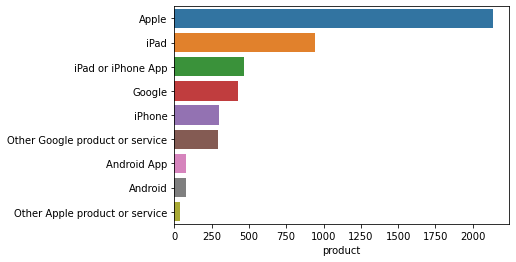

In [15]:
x = df['product'].value_counts()
y = x.index
sns.barplot(x=x, y=y);

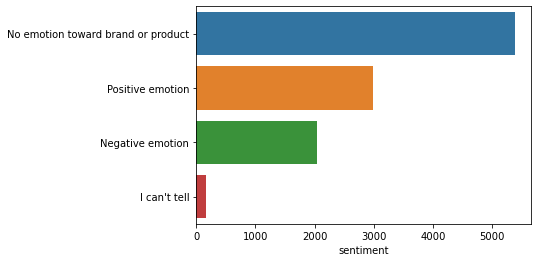

In [16]:
x = df['sentiment'].value_counts()
y = x.index
sns.barplot(x=x, y=y);

In [17]:
df['tweet'] = df['tweet'].astype(str)

In [18]:
def replace_emoticons(text):
    # Define a dictionary mapping emoticons to their corresponding meanings
    emoticon_mapping = {
        ':D': 'emojismile',
        ':)': 'emojismile',
        ':-D': 'emojismile',
        ':\'': 'emojiunsure',
        ':p': 'emojitongue',
        ':P': 'emojitongue',
        ':(': 'emojisad'
        # Add more emoticons and their meanings as needed
    }
    pattern = re.compile('|'.join(re.escape(emoticon) for emoticon in emoticon_mapping.keys()))
    def replace(match):
        return emoticon_mapping[match.group(0)]

    return pattern.sub(replace, text)


In [19]:
df['tweet'] = df['tweet'].apply(replace_emoticons)

In [20]:
df['tweet'][260]

'Our #sxsw app is now on #android emojismile huge props to @mention @mention @mention &amp; @mention Get it now: {link}'

In [21]:
def preprocess_tweet(tweet):
    # Remove links and mentions
    tweet = re.sub(r'http\S+|@\S+', '', tweet)
    
    # Remove {link}
    tweet = re.sub(r'\{link\}', '', tweet)
    
    # Replace &quot; with "
    tweet = tweet.replace('&quot;', '"')
    
    # Remove extra space between quotation mark and words
    tweet = re.sub(r'\s+"', '"', tweet)
    tweet = re.sub(r'"\s+', '"', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove punctuation
    tweet = re.sub(r'([^\w\s]|_)+', ' ', tweet)
    
    # Tokenize
    tokens = nltk.word_tokenize(tweet)
    
    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for word, pos in tagged_tokens:
        if pos.startswith('J'):
            pos = 'a'  # Adjective
        elif pos.startswith('V'):
            pos = 'v'  # Verb
        elif pos.startswith('N'):
            pos = 'n'  # Noun
        elif pos.startswith('R'):
            pos = 'r'  # Adverb
        else:
            pos = 'n'  # Default to noun
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_tokens.append(lemma)
    
    # Add additional stopwords
    additional_stopwords = {'w', 'u', 'amp', 'sxsw', 'rt'}  # amp = & 
    stop_words = set(stopwords.words('english')) | additional_stopwords
    
    # Remove stopwords
    tweet = [word for word in tokens if word not in stop_words]
    
    return tweet

In [22]:
df['tweet'] = df['tweet'].astype(str).apply(preprocess_tweet)

In [23]:
df.head()

,tweet,product,sentiment
0,"[g, iphone, hrs, tweeting, rise, austin, dead,...",iPhone,Negative emotion
1,"[know, awesome, ipad, iphone, app, likely, app...",iPad or iPhone App,Positive emotion
2,"[wait, ipad, also, sale]",iPad,Positive emotion
3,"[hope, year, festival, crashy, year, iphone, app]",iPad or iPhone App,Negative emotion
4,"[great, stuff, fri, marissa, mayer, google, ti...",Google,Positive emotion


In [24]:
df['tweet'][65]

['agree',
 'wait',
 'fiona',
 'apple',
 'town',
 'somebody',
 'kidnap',
 'put',
 'recording',
 'studio',
 'records',
 'new',
 'album']

In [25]:
# combined and renamed Apple products and non Apple products 

df['product'] = df['product'].replace({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Other',
    'Other Google product or service': 'Other',
    'Android App': 'Other',
    'Android': 'Other'
})
#there are 5802 rows that are null - what should we do with those?

In [26]:
df.head()

,tweet,product,sentiment
0,"[g, iphone, hrs, tweeting, rise, austin, dead,...",Apple,Negative emotion
1,"[know, awesome, ipad, iphone, app, likely, app...",Apple,Positive emotion
2,"[wait, ipad, also, sale]",Apple,Positive emotion
3,"[hope, year, festival, crashy, year, iphone, app]",Apple,Negative emotion
4,"[great, stuff, fri, marissa, mayer, google, ti...",Other,Positive emotion


In [27]:
stopwords_list = stopwords.words('english')

# Print the stopwords
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
df['product'].value_counts()

Apple    3885
Other     882
Name: product, dtype: int64

In [29]:
df= df[df['product']=='Apple']

In [30]:
df['sentiment'].value_counts()

Positive emotion                      1949
Negative emotion                      1864
No emotion toward brand or product      65
I can't tell                             7
Name: sentiment, dtype: int64

In [31]:
df['sentiment']=df['sentiment'].replace("I can't tell", "No emotion toward brand or product")

In [32]:
df['sentiment'].value_counts()

Positive emotion                      1949
Negative emotion                      1864
No emotion toward brand or product      72
Name: sentiment, dtype: int64

In [33]:
df = df.drop(df[df['sentiment'] == 'No emotion toward brand or product'].index)

In [34]:
df['sentiment'].value_counts()

Positive emotion    1949
Negative emotion    1864
Name: sentiment, dtype: int64

In [35]:
df['target'] = df['sentiment'].map({'Positive emotion': 1, 'Negative emotion': 0})

In [36]:
df

,tweet,product,sentiment,target
0,"[g, iphone, hrs, tweeting, rise, austin, dead,...",Apple,Negative emotion,0
1,"[know, awesome, ipad, iphone, app, likely, app...",Apple,Positive emotion,1
2,"[wait, ipad, also, sale]",Apple,Positive emotion,1
3,"[hope, year, festival, crashy, year, iphone, app]",Apple,Negative emotion,0
8,"[beautifully, smart, simple, idea, wrote, holl...",Apple,Positive emotion,1
...,...,...,...,...
10564,"[feel, like, apple, product, updates, reruns, ...",Apple,Negative emotion,0
10565,"[apple, latest, feature, making, wish, updated...",Apple,Negative emotion,0
10566,"[thought, device, perfect, apple, finds, way, ...",Apple,Negative emotion,0
10567,"[apple, latest, innovation, convincing, us, ne...",Apple,Negative emotion,0


In [37]:
# Convert tokenized tweets back into strings
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))

# train test split
X = df['tweet']
y = df['target'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))  #ngram_range=(1,2)

# Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [39]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [40]:
y_preds_lr = logreg.predict(X_train_tfidf)

In [41]:
print(classification_report(y_train, y_preds_lr))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1417
           1       0.96      0.99      0.97      1442

    accuracy                           0.97      2859
   macro avg       0.98      0.97      0.97      2859
weighted avg       0.97      0.97      0.97      2859



In [42]:
y_test_preds_lr = logreg.predict(X_test_tfidf)
print(classification_report(y_test,y_test_preds_lr))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       447
           1       0.90      0.92      0.91       507

    accuracy                           0.90       954
   macro avg       0.90      0.90      0.90       954
weighted avg       0.90      0.90      0.90       954



In [43]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [44]:
y_preds_nmb = mnb.predict(X_train_tfidf)
y_preds_test_nmb = mnb.predict(X_test_tfidf)

In [45]:
print(classification_report(y_train, y_preds_nmb))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1417
           1       0.97      1.00      0.98      1442

    accuracy                           0.98      2859
   macro avg       0.98      0.98      0.98      2859
weighted avg       0.98      0.98      0.98      2859



In [46]:
print(classification_report(y_test, y_preds_test_nmb))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       447
           1       0.90      0.94      0.92       507

    accuracy                           0.91       954
   macro avg       0.91      0.91      0.91       954
weighted avg       0.91      0.91      0.91       954



In [47]:
svc = SVC(random_state=42)
svc.fit(X_train_tfidf, y_train)

SVC(random_state=42)

In [48]:
y_preds_svc = svc.predict(X_train_tfidf)
y_preds_test_svc = svc.predict(X_test_tfidf)

In [49]:
print(classification_report(y_train, y_preds_svc))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1417
           1       0.99      1.00      1.00      1442

    accuracy                           1.00      2859
   macro avg       1.00      1.00      1.00      2859
weighted avg       1.00      1.00      1.00      2859



In [50]:
print(classification_report(y_test, y_preds_test_svc))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       447
           1       0.91      0.93      0.92       507

    accuracy                           0.91       954
   macro avg       0.91      0.91      0.91       954
weighted avg       0.91      0.91      0.91       954



In [51]:
params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':[2,3,4],
          'shrinking':[True,False],
         }

In [52]:
svc_grid = GridSearchCV(svc, param_grid=params, cv=5)

In [53]:
start = time.time()
svc_grid.fit(X_train_tfidf, y_train)
end = time.time()
print(f'{end-start} seconds')

105.12970662117004 seconds


In [54]:
svc_grid.best_estimator_

SVC(degree=2, kernel='linear', random_state=42)

In [55]:
svc_grid.best_score_

0.9048657122212289

In [60]:
svc_tuned = SVC(degree=2, kernel='poly', random_state=42)
svc_tuned.fit(X_train_tfidf, y_train)

SVC(degree=2, kernel='poly', random_state=42)

In [61]:
y_preds_svc = svc_tuned.predict(X_train_tfidf)
y_preds_test_svc = svc_tuned.predict(X_test_tfidf)

In [62]:
print(classification_report(y_train, y_preds_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1417
           1       1.00      1.00      1.00      1442

    accuracy                           1.00      2859
   macro avg       1.00      1.00      1.00      2859
weighted avg       1.00      1.00      1.00      2859



In [63]:
print(classification_report(y_test, y_preds_test_svc))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       447
           1       0.91      0.94      0.92       507

    accuracy                           0.92       954
   macro avg       0.92      0.92      0.92       954
weighted avg       0.92      0.92      0.92       954



In [69]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [70]:
y_preds_rf = rf.predict(X_train_tfidf)
y_preds_test_rf = rf.predict(X_test_tfidf)

In [71]:
print(classification_report(y_train, y_preds_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1417
           1       1.00      1.00      1.00      1442

    accuracy                           1.00      2859
   macro avg       1.00      1.00      1.00      2859
weighted avg       1.00      1.00      1.00      2859



In [72]:
print(classification_report(y_test, y_preds_test_rf))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       447
           1       0.89      0.91      0.90       507

    accuracy                           0.89       954
   macro avg       0.89      0.89      0.89       954
weighted avg       0.89      0.89      0.89       954



In [73]:
rf_params = {'n_estimators':[10, 50, 100],
             'criterion':['gini','entropy','log_loss'],
             'max_depth':[5,10,20]
            }

In [74]:
rf_grid = GridSearchCV(rf, param_grid=rf_params, cv=5)

In [75]:
rf_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [10, 50, 100]})

In [78]:
print(rf_grid.best_score_)
print(rf_grid.best_estimator_)
print(rf_grid.best_params_)

0.8481978616829755
RandomForestClassifier(max_depth=20)
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}


In [79]:
rf2 = RandomForestClassifier(criterion='gini', max_depth=20, n_estimators=100)
rf2.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=20)

In [80]:
y_preds_rf2 = rf2.predict(X_train_tfidf)
y_preds_test_rf2 = rf2.predict(X_test_tfidf)

In [81]:
print(classification_report(y_train, y_preds_rf2))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1417
           1       0.85      0.96      0.90      1442

    accuracy                           0.90      2859
   macro avg       0.90      0.89      0.89      2859
weighted avg       0.90      0.90      0.89      2859



In [82]:
print(classification_report(y_test, y_preds_test_rf2))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       447
           1       0.81      0.90      0.85       507

    accuracy                           0.84       954
   macro avg       0.84      0.83      0.83       954
weighted avg       0.84      0.84      0.83       954

